# Roller Coaster Classification

## By Damien Ha

### Libraries and Helper Functions

In [1]:
# All the necessary libraries for this project
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import itertools
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline

In [2]:
# Helper function drawing a nicely formatted heatmap
def heatmap(data, row_labels, col_labels, figsize = (20,12), cmap = "YlGn",
            cbar_kw={}, cbarlabel="", valfmt="{x:.2f}",
            textcolors=("black", "white"), threshold=None):
    """
    Create a heatmap from a numpy array and two lists of labels. 

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cmap
        A string that specifies the colormap to use. Look at matplotlib docs for information.
        Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
    """

    plt.figure(figsize = figsize)
    ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data,cmap=cmap)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    
    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

In [3]:
# Helper function that allows you to draw nicely formatted confusion matrices
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn and discussion example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.YlOrBr)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)
    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

### Data Exploration and Cleaning

In [4]:
df = pd.read_csv('roller_coasters.csv')

In [5]:
df.head()

,name,material_type,seating_type,speed,height,length,num_inversions,manufacturer,park,status
0,Goudurix,Steel,Sit Down,75.0,37.0,950.0,7.0,Vekoma,Parc Asterix,status.operating
1,Dream catcher,Steel,Suspended,45.0,25.0,600.0,0.0,Vekoma,Bobbejaanland,status.operating
2,Alucinakis,Steel,Sit Down,30.0,8.0,250.0,0.0,Zamperla,Terra Mítica,status.operating
3,Anaconda,Wooden,Sit Down,85.0,35.0,1200.0,0.0,William J. Cobb,Walygator Parc,status.operating
4,Azteka,Steel,Sit Down,55.0,17.0,500.0,0.0,Soquet,Le Pal,status.operating


In [6]:
#Take note of the variables, these are the quantitative variables
df.describe()

,speed,height,length,num_inversions
count,1478.000000,1667.000000,1675.000000,2405.000000
mean,70.102842,26.725855,606.147463,0.809563
std,28.338394,35.010166,393.840496,1.652254
min,0.000000,0.000000,-1.000000,0.000000
25%,47.000000,13.000000,335.000000,0.000000
50%,72.000000,23.000000,500.000000,0.000000
75%,88.000000,35.000000,839.000000,1.000000
max,240.000000,902.000000,2920.000000,14.000000


In [7]:
# Take note of the 'object' dtypes. These will have to be dropped or encoded
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2802 entries, 0 to 2801
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            2799 non-null   object 
 1   material_type   2802 non-null   object 
 2   seating_type    2802 non-null   object 
 3   speed           1478 non-null   float64
 4   height          1667 non-null   float64
 5   length          1675 non-null   float64
 6   num_inversions  2405 non-null   float64
 7   manufacturer    2802 non-null   object 
 8   park            2802 non-null   object 
 9   status          2802 non-null   object 
dtypes: float64(4), object(6)
memory usage: 219.0+ KB


In [8]:
df.isna().sum()

name                 3
material_type        0
seating_type         0
speed             1324
height            1135
length            1127
num_inversions     397
manufacturer         0
park                 0
status               0
dtype: int64

In [9]:
df.shape

(2802, 10)

In [10]:
# Eliminate the qualitative variable NAs as there are not too many
df = df[df['name'].notna()]

In [11]:
df.isna().sum()

name                 0
material_type        0
seating_type         0
speed             1324
height            1135
length            1127
num_inversions     397
manufacturer         0
park                 0
status               0
dtype: int64

In [12]:
# The quantitative variable NAs are numerous so we shall impute them with the averages
num = ['speed', 'height', 'length', 'num_inversions']
for i in num:
    mean_value=df[i].mean()
    df[i].fillna(value=mean_value, inplace=True)

In [13]:
# Double check the remaining number of NAs is 0
df.isna().sum()

name              0
material_type     0
seating_type      0
speed             0
height            0
length            0
num_inversions    0
manufacturer      0
park              0
status            0
dtype: int64

In [14]:
# Material will be our target for classification, so let's see its values
df['material_type'].unique()

array(['Steel', 'Wooden', 'Hybrid', 'na'], dtype=object)

In [15]:
# 'na' in this case probably means NA, coasters are either wood, steel, or hybrid, there aren't other categories
# We will probably want to be rid of it
df = df[df['material_type'] != 'na']

In [16]:
# Let's see how much data remains after removing those values. Looks like it's still a sizeable amount
df.shape

(2268, 10)

In [17]:
# Encode material as it is our target variable. Drop it afterward and check our data
le = LabelEncoder()
df['target'] = le.fit_transform(df['material_type'])
df = df.drop(columns = ['material_type'])
df.head()

,name,seating_type,speed,height,length,num_inversions,manufacturer,park,status,target
0,Goudurix,Sit Down,75.0,37.0,950.0,7.0,Vekoma,Parc Asterix,status.operating,1
1,Dream catcher,Suspended,45.0,25.0,600.0,0.0,Vekoma,Bobbejaanland,status.operating,1
2,Alucinakis,Sit Down,30.0,8.0,250.0,0.0,Zamperla,Terra Mítica,status.operating,1
3,Anaconda,Sit Down,85.0,35.0,1200.0,0.0,William J. Cobb,Walygator Parc,status.operating,2
4,Azteka,Sit Down,55.0,17.0,500.0,0.0,Soquet,Le Pal,status.operating,1


In [18]:
# Double check target classes
print(le.classes_)

['Hybrid' 'Steel' 'Wooden']


### Visualizations

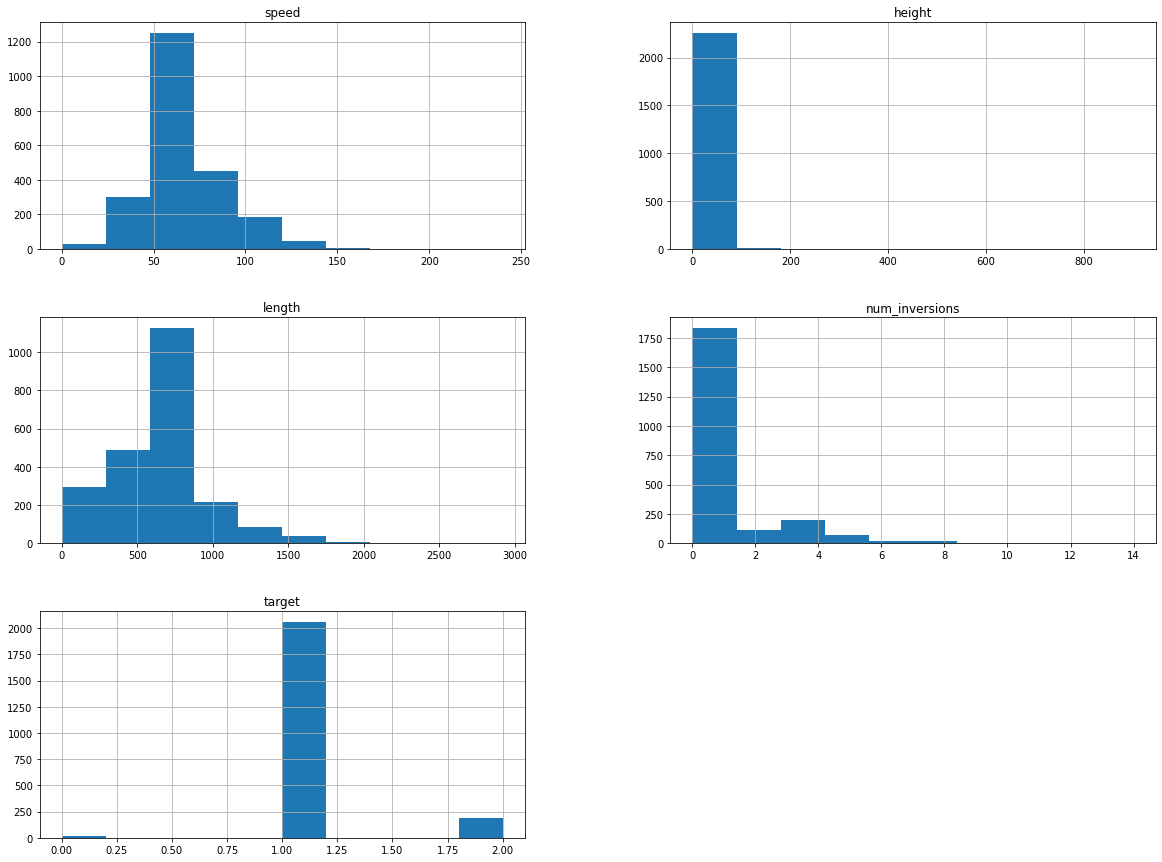

In [19]:
# Histograms of quantitative variables so we know what we're working with
# Speed looks close to normal. Length, height, and inversions look a bit skewed
# This seems reflective of what we'd expect in the world of roller coasters
df.hist(figsize = (20,15))
plt.show()

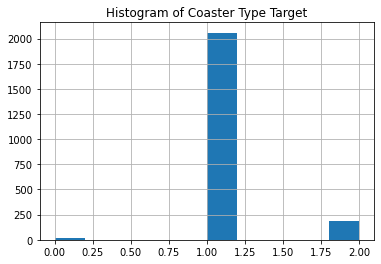

target
1    2058
2     189
0      21
Name: count, dtype: int64

In [20]:
# Steel is pretty clearly represented much more over wood and hybrid as we see here
# This is simply reflective of the real world; that said we should be mindful of this in our results
df['target'].hist()
plt.title('Histogram of Coaster Type Target')
plt.show()
df['target'].value_counts()

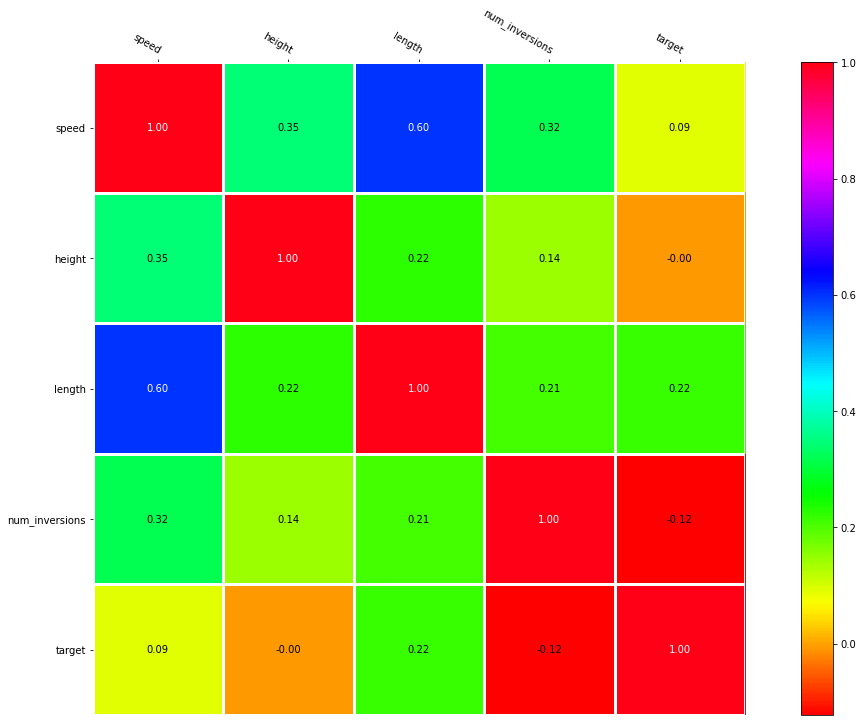

In [21]:
# Let's quickly visualize the coorrelations of our variables
correlations = df[['speed', 'height', 'length', 'num_inversions', 'target']].corr()
columns = list(df[['speed', 'height', 'length', 'num_inversions', 'target']])
heatmap(correlations.values,columns,columns,figsize = (20,12),cmap="hsv")

In [22]:
correlations["target"].sort_values(ascending=False)

target            1.000000
length            0.216957
speed             0.092346
height           -0.004072
num_inversions   -0.122361
Name: target, dtype: float64

### Data Pre-Processing

In [23]:
y = df["target"]
x = df.drop(["target"],axis = 1)

In [24]:
train_raw, test_raw, target, target_test = train_test_split(x, y, test_size = 0.2, stratify = y, random_state=0)

In [25]:
print("Training shape:", train_raw.shape)
print("Testing shape:", test_raw.shape)

Training shape: (1814, 9)
Testing shape: (454, 9)


In [26]:
print("Training set class counts:", np.bincount(target))
print("Testing set class counts:", np.bincount(target_test))

Training set class counts: [  17 1646  151]
Testing set class counts: [  4 412  38]


In [27]:
# Drop variables that do not help the classification of material type
df = df.drop(columns = ['name', 'park'])

# Seperate numerical and categorical variables
num = ['speed', 'height', 'length', 'num_inversions']
cat = ['seating_type', 'manufacturer', 'status']

# Transform numerical with `StandardScaler()` and categorical with `OneHotEncoder()`
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num), 
    ('cat', OneHotEncoder(sparse_output = False, handle_unknown = 'ignore', categories = 'auto', drop = 'first'), cat)])

# Create Pipeline. We will try KNN first
pipeline = Pipeline([('preprocessor', preprocessor), ('knn', KNeighborsClassifier(n_neighbors=3))])

# Create training and testing sets by transforming raw data through pipeline 
train = pipeline['preprocessor'].fit_transform(train_raw)
test = pipeline['preprocessor'].transform(test_raw)

pipeline['knn'].fit(train, target)

feature_names = pipeline[:-1].get_feature_names_out()
print(feature_names)

['num__speed' 'num__height' 'num__length' 'num__num_inversions'
 'cat__seating_type_Alpine' 'cat__seating_type_Bobsleigh'
 'cat__seating_type_Floorless' 'cat__seating_type_Flying'
 'cat__seating_type_Inverted' 'cat__seating_type_Motorbike'
 'cat__seating_type_Pipeline' 'cat__seating_type_Sit Down'
 'cat__seating_type_Spinning' 'cat__seating_type_Stand Up'
 'cat__seating_type_Suspended' 'cat__seating_type_Water Coaster'
 'cat__seating_type_Wing' 'cat__seating_type_na'
 'cat__manufacturer_ART Engineering' 'cat__manufacturer_Abc rides'
 'cat__manufacturer_Allan Herschell Company' 'cat__manufacturer_Arrow'
 'cat__manufacturer_B&M' 'cat__manufacturer_B. A. Schiff & Associates'
 'cat__manufacturer_Barbisan' 'cat__manufacturer_Beijing Jiuhua'
 'cat__manufacturer_Beijing Shibaolai'
 'cat__manufacturer_Beto Carrero World'
 'cat__manufacturer_Big Country Mitioneering'
 'cat__manufacturer_Blackpool Leisure' 'cat__manufacturer_Bradley & Kaye'
 'cat__manufacturer_Brandauer' 'cat__manufacturer_CAM B

/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### Trying Machine Learning Models

#### KNN

In [28]:
# K-Nearest Neighbors
predicted = pipeline['knn'].predict(test)

accuracy = accuracy_score(target_test, predicted)

print("Accuracy:", accuracy)

n_values = [1, 2, 3, 5, 7, 9, 10, 20, 50]
accuracies = []

for n in n_values:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(train, target)
    
    predicted = knn.predict(test)
    
    accuracy = accuracy_score(target_test, predicted)
    accuracies.append(accuracy)

for n, accuracy in zip(n_values, accuracies):
    print(f"n_neighbors = {n}: Accuracy = {accuracy}")

Accuracy: 0.947136563876652
n_neighbors = 1: Accuracy = 0.9515418502202643
n_neighbors = 2: Accuracy = 0.947136563876652
n_neighbors = 3: Accuracy = 0.947136563876652
n_neighbors = 5: Accuracy = 0.9449339207048458
n_neighbors = 7: Accuracy = 0.9493392070484582
n_neighbors = 9: Accuracy = 0.9427312775330396
n_neighbors = 10: Accuracy = 0.9405286343612335
n_neighbors = 20: Accuracy = 0.9295154185022027
n_neighbors = 50: Accuracy = 0.9140969162995595


#### Logistic Regression

Test Accuracy: 0.9537444933920705


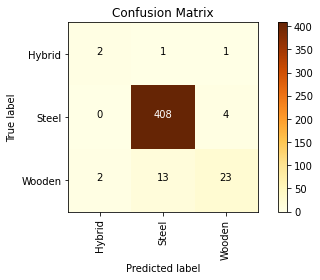

In [29]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(train, target)

predicted = logreg.predict(test)

accuracy = accuracy_score(target_test, predicted)
print("Test Accuracy:", accuracy)

draw_confusion_matrix(target_test, predicted, classes = ['Hybrid', 'Steel', 'Wooden'])

Test Accuracy: 0.9537444933920705


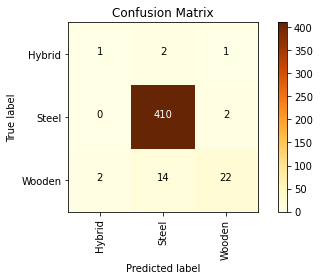

In [30]:
# Adjust some hyperparameters of logistic regression and see how accuracy changes
logreg = LogisticRegression(solver= 'liblinear', max_iter= 1000, penalty = 'l2', C=1)
logreg.fit(train, target)

predicted = logreg.predict(test)

accuracy = accuracy_score(target_test, predicted)
print("Test Accuracy:", accuracy)

draw_confusion_matrix(target_test, predicted, classes = ['Hybrid', 'Steel', 'Wooden'])

Test Accuracy: 0.9074889867841409


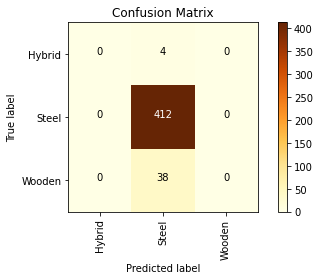

In [31]:
# More logistic regression
logreg = LogisticRegression(solver= 'liblinear', max_iter= 1000, penalty = 'l2', C=0.0001)
logreg.fit(train, target)

predicted = logreg.predict(test)

accuracy = accuracy_score(target_test, predicted)
print("Test Accuracy:", accuracy)

draw_confusion_matrix(target_test, predicted, classes = ['Hybrid', 'Steel', 'Wooden'])

Test Accuracy: 0.00881057268722467


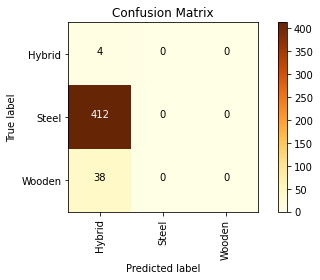

In [32]:
# This throws it off completely. Very sensitive, why? Need to explore
logreg = LogisticRegression(solver= 'liblinear', max_iter= 1000, penalty = 'l1', C=0.0001)
logreg.fit(train, target)

predicted = logreg.predict(test)

accuracy = accuracy_score(target_test, predicted)
print("Test Accuracy:", accuracy)

draw_confusion_matrix(target_test, predicted, classes = ['Hybrid', 'Steel', 'Wooden'])

#### SVM

In [33]:
# Support Vector Machines
svm = SVC()
svm.fit(train, target)
predicted = svm.predict(test)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Number of support vectors:", svm.n_support_)

Accuracy:    0.953744
Number of support vectors: [ 17 282 120]


In [34]:
# Linear SVM is the same as non-linear in this case, need to explore why that might be 
svm = SVC(kernel = 'linear')
svm.fit(train, target)
predicted = svm.predict(test)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Number of support vectors:", svm.n_support_)

Accuracy:    0.953744
Number of support vectors: [ 16 250  99]


#### Decision Tree

Accuracy:    0.944934


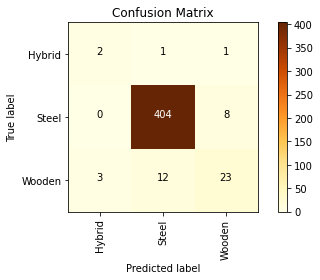

In [35]:
# Decision Tree
clf = DecisionTreeClassifier(criterion="gini", random_state = 0)
clf.fit(train, target)
predicted = clf.predict(test)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
draw_confusion_matrix(target_test, predicted, classes = ['Hybrid', 'Steel', 'Wooden'])

[Text(0.5, 0.8333333333333334, 'num__length <= 0.722\ngini = 0.17\nsamples = 100.0%\nvalue = [0.009, 0.907, 0.083]'),
 Text(0.25, 0.5, 'cat__manufacturer_Gravity Group <= 0.5\ngini = 0.075\nsamples = 83.1%\nvalue = [0.003, 0.961, 0.036]'),
 Text(0.125, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.375, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.75, 0.5, 'num__num_inversions <= 0.084\ngini = 0.484\nsamples = 16.9%\nvalue = [0.039, 0.644, 0.317]'),
 Text(0.625, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.875, 0.16666666666666666, '\n  (...)  \n')]

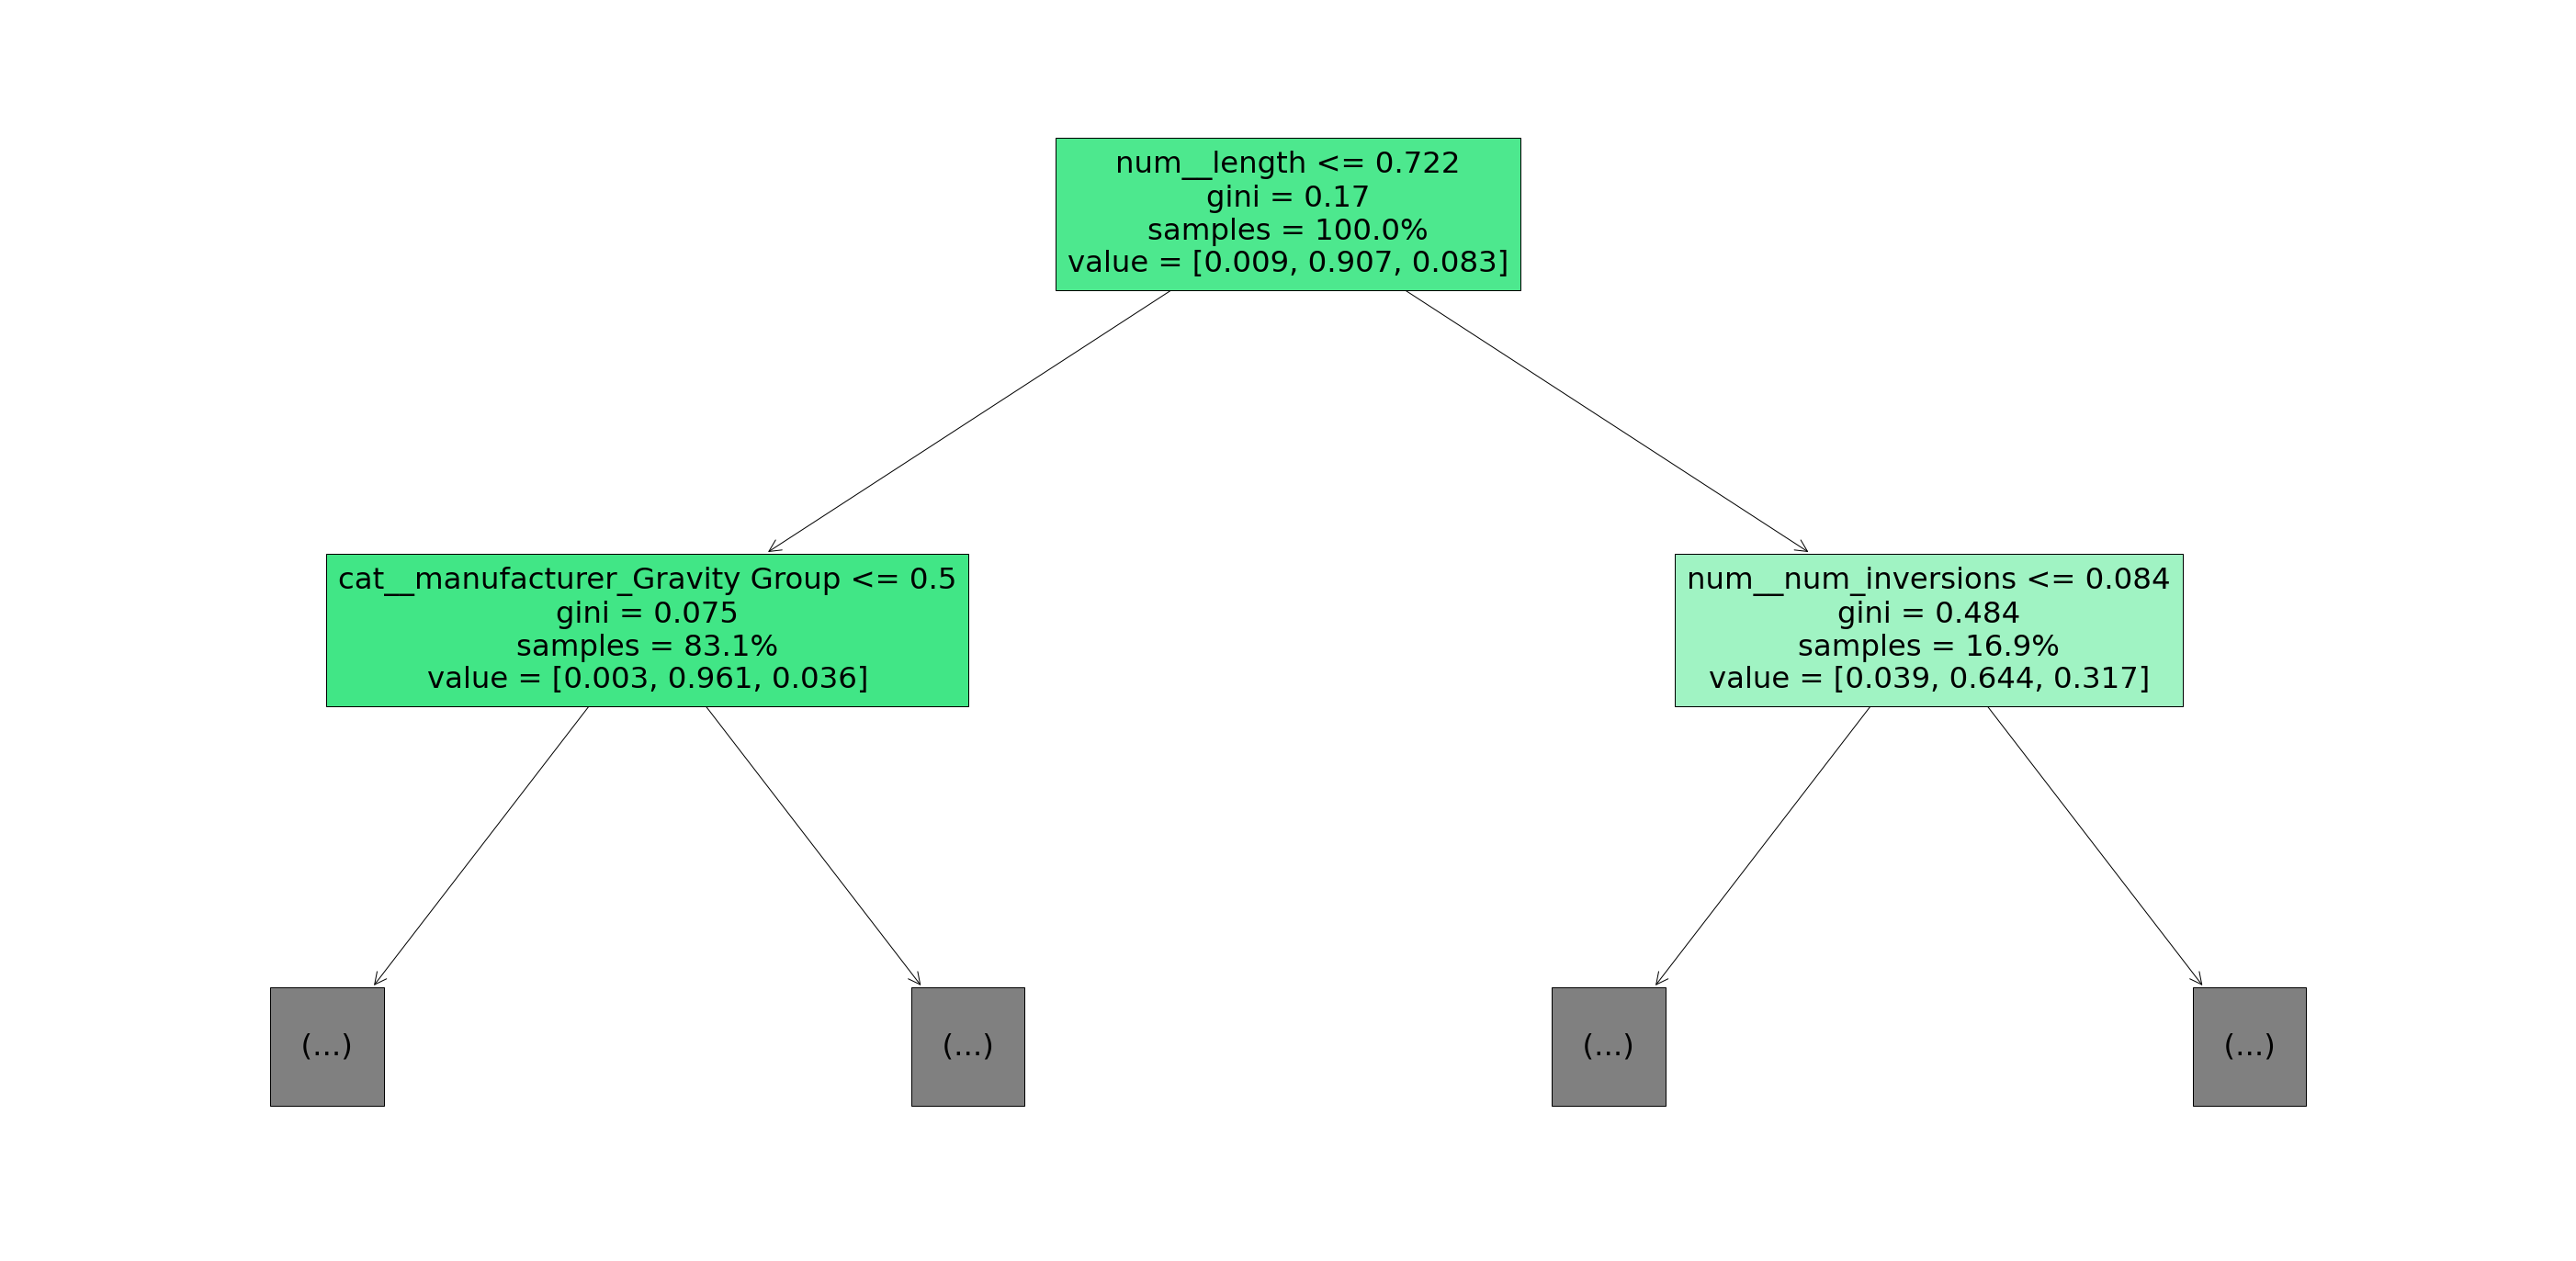

In [36]:
# Visualize some layers of the decision tree
plt.figure(figsize = (50,25)) 
sklearn.tree.plot_tree(clf,max_depth=1, proportion=True,feature_names=feature_names, filled=True)

In [37]:
# Use grid search to find the best parameters of decision tree and its accuracy
param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 10, 15],
    'min_samples_split': [2, 4, 6, 8],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3)

grid_search.fit(train, target)


print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 6}
Best score: 0.9492793680331308


#### MLP

Train Accuracy: 0.9559471365638766


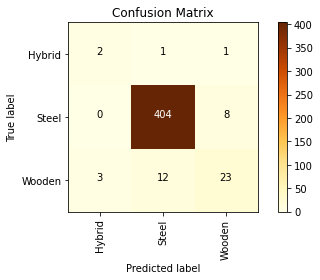

In [38]:
# Multi-Layer Perceptron
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=800, random_state=0)
mlp_classifier.fit(train, target)
y_train_pred = mlp_classifier.predict(test)
train_accuracy = accuracy_score(target_test, y_train_pred)
print("Train Accuracy:", train_accuracy)

draw_confusion_matrix(target_test, predicted, classes = ['Hybrid', 'Steel', 'Wooden'])

### F1 Score Instead of Accuracy

We can see from the confusion matrices in the above models that there are simply far more steel roller coasters than wood or hybrid. Given uneven class distribution, accuracy score may not be the best determiner of model performance. Therefore I am going to try F1 score instead. While accuracy is often easier to interpret, F1 takes into account data distribution and is therefore better for assessing model performance in imbalanced data.

The mathematical formula for F1 Score is as follows:

$F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$

While this might be harder to interpret overall compared to accuracy, the general idea is still that a value closer to 1 is better

#### KNN with F1

In [39]:
# K-Nearest Neighbors
predicted = pipeline['knn'].predict(test)

f1 = f1_score(target_test, predicted, average = None)

print("Best F1:", f1)

n_values = [1, 2, 3, 5, 7, 9, 10, 20, 50]
f1s = []

for n in n_values:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(train, target)
    
    predicted = knn.predict(test)
    
    f1 = f1_score(target_test, predicted, average = None)
    f1s.append(f1)

for n, f1 in zip(n_values, f1s):
    print(f"n_neighbors = {n}: F1's = {f1}")

Best F1: [0.5        0.9748503  0.64615385]
n_neighbors = 1: F1's = [0.57142857 0.97590361 0.70422535]
n_neighbors = 2: F1's = [0.4        0.97619048 0.62068966]
n_neighbors = 3: F1's = [0.5        0.9748503  0.64615385]
n_neighbors = 5: F1's = [0.25       0.97355769 0.67647059]
n_neighbors = 7: F1's = [0.28571429 0.97596154 0.69565217]
n_neighbors = 9: F1's = [0.         0.97122302 0.67647059]
n_neighbors = 10: F1's = [0.         0.97013142 0.63636364]
n_neighbors = 20: F1's = [0.         0.96305125 0.55384615]
n_neighbors = 50: F1's = [0.         0.95362663 0.44444444]


#### Logistic Regression with F1

F1 Score: [0.5        0.97841727 0.6969697 ]


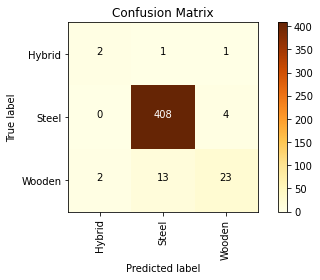

In [40]:
logreg = LogisticRegression()
logreg.fit(train, target)

predicted = logreg.predict(test)

f1 = f1_score(target_test, predicted, average = None)
print("F1 Score:", f1)

draw_confusion_matrix(target_test, predicted, classes = ['Hybrid', 'Steel', 'Wooden'])

F1 Score: 0.9506448505592804


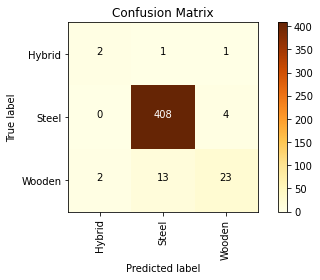

In [41]:
f1 = f1_score(target_test, predicted, average = 'weighted')
print("F1 Score:", f1)

draw_confusion_matrix(target_test, predicted, classes = ['Hybrid', 'Steel', 'Wooden'])

F1 Score: 0.9537444933920705


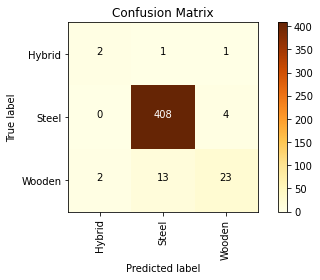

In [42]:
f1 = f1_score(target_test, predicted, average = 'micro')
print("F1 Score:", f1)

draw_confusion_matrix(target_test, predicted, classes = ['Hybrid', 'Steel', 'Wooden'])

F1 Score: 0.7251289877189158


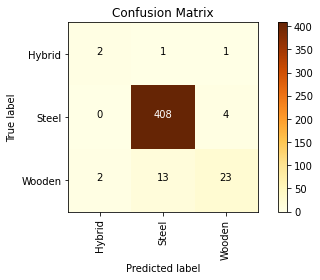

In [43]:
f1 = f1_score(target_test, predicted, average = 'macro')
print("F1 Score:", f1)

draw_confusion_matrix(target_test, predicted, classes = ['Hybrid', 'Steel', 'Wooden'])

#### SVM with F1 

In [44]:
# Support Vector Machines
svm = SVC()
svm.fit(train, target)
predicted = svm.predict(test)
print("%-12s %f" % ('F1:', metrics.f1_score(target_test, predicted, average = 'weighted')))
print("Number of support vectors:", svm.n_support_)

F1:          0.949701
Number of support vectors: [ 17 282 120]


#### Decision Tree with F1

F1:          0.943420


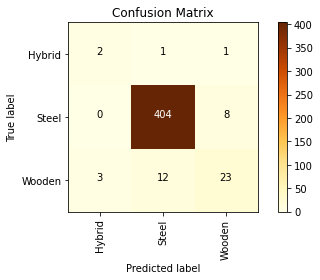

In [45]:
# Decision Tree
clf = DecisionTreeClassifier(criterion="gini", random_state = 0)
clf.fit(train, target)
predicted = clf.predict(test)
print("%-12s %f" % ('F1:', metrics.f1_score(target_test, predicted, average = 'weighted')))
draw_confusion_matrix(target_test, predicted, classes = ['Hybrid', 'Steel', 'Wooden'])

#### MLP with F1

F1: [0.         0.97954272 0.76056338]


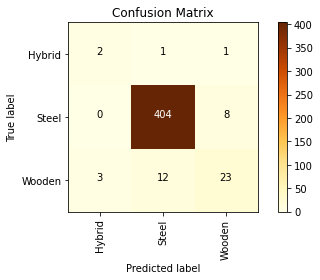

In [46]:
# Multi-Layer Perceptron
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=800, random_state=0)
mlp_classifier.fit(train, target)
y_train_pred = mlp_classifier.predict(test)
train_f1 = f1_score(target_test, y_train_pred, average = None)
print("F1:", train_f1)

draw_confusion_matrix(target_test, predicted, classes = ['Hybrid', 'Steel', 'Wooden'])

F1: 0.9525837201146521


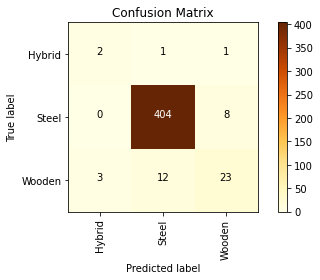

In [47]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=800, random_state=0)
mlp_classifier.fit(train, target)
y_train_pred = mlp_classifier.predict(test)
train_f1 = f1_score(target_test, y_train_pred, average = 'weighted')
print("F1:", train_f1)

draw_confusion_matrix(target_test, predicted, classes = ['Hybrid', 'Steel', 'Wooden'])